In [1]:
%load_ext autoreload
%autoreload 2

In [178]:
import src
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib

pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import logging
src.logging_config.setup_logging(logging.INFO)

Logging has been configured.


# Load Config

In [179]:
CONFIG = src.util.load_config()

2024-10-03 01:38:38,783 - src.util - INFO - Loaded CONFIG:
{
    "pred_days": 7,
    "pred_date": "2021-07-01",
    "features": [
        "loc_roll7_mean",
        "loc_roll14_mean",
        "loc_roll28_mean",
        "loc_roll56_mean",
        "loc_roll7_std",
        "loc_roll14_std",
        "loc_roll28_std",
        "loc_roll56_std",
        "location_duration_days",
        "population",
        "weekday",
        "is_sunday",
        "gap_days",
        "loc_lag0",
        "loc_lag1",
        "loc_lag2",
        "loc_lag3",
        "loc_lag4",
        "loc_lag5",
        "loc_lag6",
        "new_vaccinated_rate",
        "cumsum_vaccinated_rate",
        "loc_rain_roll7_sum",
        "loc_rain_roll14_sum",
        "loc_rain_roll28_sum",
        "loc_rain_roll56_sum",
        "location_key_encoded",
        "latitude",
        "longitude",
        "relative_humidity",
        "loc_same_weekday_roll2_mean",
        "loc_same_weekday_roll3_mean",
        "loc_same_weekday_roll4_mean

# Feature Pipeline

In [148]:
%%time

covid_data_loader = src.features.CovidDataLoader(level=1)
target_creator = src.features.TargetCreator(shift_day=1)    # 1-day shift
weekday = src.features.Weekday()
is_sunday = src.features.IsSunday()
location_rolling_mean = src.features.LocationRollingMean(shift_day=0, rolling_days=[7, 14, 28, 56])
location_rolling_std = src.features.LocationRollingStd(shift_day=0, rolling_days=[7, 14, 28, 56])
location_same_weekday_rolling_mean = src.features.LocationSameWeekDayRollingMean(shift_day=0, rolling_days=[2,3,4,5,6,7,8])
location_duration_days = src.features.LocationDurationDays()
location_lag = src.features.LocationLag(lag_days=[0,1,2,3,4,5,6])
country_population = src.features.CountryPopulation()
country_rolling_mean = src.features.CountryRollingMean(shift_day=0, rolling_days=[7, 14, 28, 56])
country_rolling_std = src.features.CountryRollingStd(shift_day=0, rolling_days=[7, 14, 28, 56])
distance_from_city = src.features.DistanceFromCity()
encoder = src.features.MinDateEncoder()
ratio_feature = src.features.RatioFeature()
missing_value = src.features.MissingValue(features=CONFIG['recursive_model_features'])

pipeline = [covid_data_loader, 
            target_creator,    
            weekday,
            is_sunday,
            location_rolling_mean,
            location_rolling_std,
            location_same_weekday_rolling_mean,
            location_duration_days,
            location_lag,
            country_population,
            country_rolling_mean,
            country_rolling_std,
            encoder,
            distance_from_city,
            ratio_feature,
            missing_value,
           ]
df = None
for t in pipeline:
    if hasattr(t, 'fit'):
        t.fit(df)
    df = t.transform(df)

2024-10-03 01:28:44,455 - src.features - INFO - ---- Covid Data Loader --------
2024-10-03 01:28:44,456 - src.features - INFO -   loading dataset ...
2024-10-03 01:28:49,177 - src.features - INFO -   cleaning dataset ...
2024-10-03 01:28:53,714 - src.features - INFO -   sorting dataset by location and date...
2024-10-03 01:28:53,998 - src.features - INFO - ---- Target Creator (new_confirmed / population * 100) --------
2024-10-03 01:28:54,000 - src.features - INFO -  shifting -1 day(s)...
2024-10-03 01:28:54,001 - src.util - INFO - truncating target outliers ...
2024-10-03 01:28:54,407 - src.features - INFO - ---- Week day --------
2024-10-03 01:28:54,435 - src.features - INFO - ---- Is Sunday--------
2024-10-03 01:28:54,464 - src.features - INFO - ---- Location Rolling Mean Feature --------
2024-10-03 01:28:54,465 - src.features - INFO - rolling 7 days -> loc_roll7_mean
2024-10-03 01:28:55,013 - src.features - INFO - rolling 14 days -> loc_roll14_mean
2024-10-03 01:28:55,427 - src.fea

CPU times: user 39.4 s, sys: 1.88 s, total: 41.3 s
Wall time: 43.1 s


# CV Tuning

In [314]:
def compute_cv_score(df, CONFIG, tuning_param):
    cv_score = {}
    # Cross Validation Score (1-day shift)
    for i, cv_date in enumerate(["2021-06-17", "2021-06-24"]):
        # train / test split
        cv_train_df, cv_test_df = src.util.train_test_split(df, 
                                                            ref_date=cv_date, 
                                                            pred_days=CONFIG["pred_days"],
                                                            gap_days=1)

        # train
        lgb_model = src.models.LGBRecursiveForecastModel(full_df = df,
                                                         recursion_pipeline = [location_rolling_mean,
                                                                               location_rolling_std,
                                                                               location_same_weekday_rolling_mean,
                                                                               location_lag],
                                                         features = CONFIG["recursive_model_features"], 
                                                         lgb_params = CONFIG["lgb_params"], 
                                                         num_boost_round=300, 
                                                         importance_coverage=tuning_param['importance_coverage'],
                                                         seed=30,
                                                         verbose=0)
        lgb_model.fit(cv_train_df)
        
        # compute score
        cv_pred_df = lgb_model.transform(cv_test_df)
        cv_score[f'cv{i}'] = src.util.score(cv_pred_df['population'], cv_pred_df['prediction'], cv_pred_df['target'])
        print(i, cv_score)
        
    mu = float(np.mean(list(cv_score.values())))
    std = float(np.std(list(cv_score.values())))
    cv_score['mean'] = mu
    cv_score['std'] = std
    return cv_score

In [315]:
# Hyper parameter Tuning Demo
tuning_df = pd.DataFrame(columns=['importance_coverage', 'cv_score_mean', 'cv_store_std'])

# Grid search
for i, importance_coverage in enumerate([0.85, 0.9, 0.95]):
    cv_score = compute_cv_score(df, CONFIG, {"importance_coverage": importance_coverage})
    tuning_df.loc[i] = [importance_coverage, cv_score['mean'], cv_score['std']]

display(tuning_df)

2021-06-16 00:00:00 0.0016861354896154687
2021-06-17 00:00:00 0.0021298138607137723
2021-06-18 00:00:00 0.0019278899586959426
2021-06-19 00:00:00 0.0018857709541776604
2021-06-20 00:00:00 0.0024154854845333095
2021-06-21 00:00:00 0.0023762415682205486


2024-10-03 05:29:48,273 - src.util - INFO - train / test split: 
  gap days = 1
  2020-05-01 <= train <= 2021-06-22
  2021-06-23 <= test <= 2021-06-29
2024-10-03 05:29:48,401 - src.util - INFO - train size: 264980; test_size: 4832
2024-10-03 05:29:48,413 - src.models - INFO - ---- LightGBM Recursive Forecast Model fitting --------
2024-10-03 05:29:48,415 - src.models - INFO -     round 1: fit all 35 features ...


2021-06-22 00:00:00 0.0022919375388984363
0 {'cv0': 0.0021522329865049463}


2024-10-03 05:29:56,634 - src.models - INFO -     round 2: fit top 21 features ...
2024-10-03 05:30:02,723 - src.models - INFO - ---- LightGBM Recursive Forecast Model transform --------


2021-06-23 00:00:00 0.0014881651913334557
2021-06-24 00:00:00 0.0016670982118598106
2021-06-25 00:00:00 0.0019250501774903106
2021-06-26 00:00:00 0.002036138070272066
2021-06-27 00:00:00 0.0028464047529006757
2021-06-28 00:00:00 0.002592576457613276


2024-10-03 05:31:54,431 - src.util - INFO - train / test split: 
  gap days = 1
  2020-05-01 <= train <= 2021-06-15
  2021-06-16 <= test <= 2021-06-22
2024-10-03 05:31:54,572 - src.util - INFO - train size: 260141; test_size: 4839
2024-10-03 05:31:54,576 - src.models - INFO - ---- LightGBM Recursive Forecast Model fitting --------
2024-10-03 05:31:54,579 - src.models - INFO -     round 1: fit all 35 features ...


2021-06-29 00:00:00 0.004057425342587479
1 {'cv0': 0.0021522329865049463, 'cv1': 0.002242655199556095}


2024-10-03 05:32:02,548 - src.models - INFO -     round 2: fit top 24 features ...
2024-10-03 05:32:09,363 - src.models - INFO - ---- LightGBM Recursive Forecast Model transform --------


2021-06-16 00:00:00 0.00168072652194747
2021-06-17 00:00:00 0.0020306337903549508
2021-06-18 00:00:00 0.0018821140953857853
2021-06-19 00:00:00 0.0018648959530982265
2021-06-20 00:00:00 0.002356551544047119
2021-06-21 00:00:00 0.0024249503858181777


2024-10-03 05:34:01,392 - src.util - INFO - train / test split: 
  gap days = 1
  2020-05-01 <= train <= 2021-06-22
  2021-06-23 <= test <= 2021-06-29
2024-10-03 05:34:01,510 - src.util - INFO - train size: 264980; test_size: 4832
2024-10-03 05:34:01,528 - src.models - INFO - ---- LightGBM Recursive Forecast Model fitting --------
2024-10-03 05:34:01,530 - src.models - INFO -     round 1: fit all 35 features ...


2021-06-22 00:00:00 0.002370108905706629
0 {'cv0': 0.0021352993154459205}


2024-10-03 05:34:09,687 - src.models - INFO -     round 2: fit top 24 features ...
2024-10-03 05:34:16,649 - src.models - INFO - ---- LightGBM Recursive Forecast Model transform --------


2021-06-23 00:00:00 0.0014685428280152106
2021-06-24 00:00:00 0.0017115840889878771
2021-06-25 00:00:00 0.00202714256292579
2021-06-26 00:00:00 0.00202442863339511
2021-06-27 00:00:00 0.002837654725624458
2021-06-28 00:00:00 0.002586980484044354


2024-10-03 05:36:09,013 - src.util - INFO - train / test split: 
  gap days = 1
  2020-05-01 <= train <= 2021-06-15
  2021-06-16 <= test <= 2021-06-22
2024-10-03 05:36:09,131 - src.util - INFO - train size: 260141; test_size: 4839
2024-10-03 05:36:09,132 - src.models - INFO - ---- LightGBM Recursive Forecast Model fitting --------
2024-10-03 05:36:09,134 - src.models - INFO -     round 1: fit all 35 features ...


2021-06-29 00:00:00 0.004051269100733689
1 {'cv0': 0.0021352993154459205, 'cv1': 0.0022552452579534055}


2024-10-03 05:36:17,084 - src.models - INFO -     round 2: fit top 28 features ...
2024-10-03 05:36:24,210 - src.models - INFO - ---- LightGBM Recursive Forecast Model transform --------


2021-06-16 00:00:00 0.0017052306006253252
2021-06-17 00:00:00 0.0020269239505740938
2021-06-18 00:00:00 0.0019005300272196143
2021-06-19 00:00:00 0.0018862702344421979
2021-06-20 00:00:00 0.0023644244289079143
2021-06-21 00:00:00 0.002424211141543375


2024-10-03 05:38:15,707 - src.util - INFO - train / test split: 
  gap days = 1
  2020-05-01 <= train <= 2021-06-22
  2021-06-23 <= test <= 2021-06-29
2024-10-03 05:38:15,820 - src.util - INFO - train size: 264980; test_size: 4832
2024-10-03 05:38:15,832 - src.models - INFO - ---- LightGBM Recursive Forecast Model fitting --------
2024-10-03 05:38:15,833 - src.models - INFO -     round 1: fit all 35 features ...


2021-06-22 00:00:00 0.002386025422914609
0 {'cv0': 0.0021486144231021836}


2024-10-03 05:38:24,547 - src.models - INFO -     round 2: fit top 28 features ...
2024-10-03 05:38:32,027 - src.models - INFO - ---- LightGBM Recursive Forecast Model transform --------


2021-06-23 00:00:00 0.0014198845472155467
2021-06-24 00:00:00 0.001687459297446601
2021-06-25 00:00:00 0.0020150506293550104
2021-06-26 00:00:00 0.002065239275737882
2021-06-27 00:00:00 0.0028556515590627217
2021-06-28 00:00:00 0.00262270040654795
2021-06-29 00:00:00 0.0040608910801623425
1 {'cv0': 0.0021486144231021836, 'cv1': 0.0022592573002665033}


,importance_coverage,cv_score_mean,cv_store_std
0,0.85,0.002197,0.000045
1,0.90,0.002195,0.000060
2,0.95,0.002204,0.000055


In [316]:
tuning_df.to_csv("./scores/recursive_model.csv", index=False)

# Prediction

In [293]:
train_df, test_df = src.util.train_test_split(df, 
                                              ref_date=CONFIG["pred_date"], 
                                              pred_days=CONFIG["pred_days"],
                                              gap_days=1
                                             )

2024-10-03 04:33:13,790 - src.util - INFO - train / test split: 
  gap days = 1
  2020-05-01 <= train <= 2021-06-29
  2021-06-30 <= test <= 2021-07-06
2024-10-03 04:33:13,952 - src.util - INFO - train size: 269812; test_size: 4828


In [304]:
models = []
for seed in [10, 20, 30]:
    lgb_model = src.models.LGBRecursiveForecastModel(full_df = df,
                                                     recursion_pipeline = [location_rolling_mean,
                                                                           location_rolling_std,
                                                                           location_same_weekday_rolling_mean,
                                                                           location_lag],
                                                     features = CONFIG["recursive_model_features"], 
                                                     lgb_params = CONFIG["lgb_params"], 
                                                     num_boost_round=300, 
                                                     importance_coverage=0.95,
                                                     seed=seed,
                                                     verbose=0)
    models.append(lgb_model)

averaged_model = src.models.AveragedModel(models=models)
averaged_model.fit(train_df)
pred_df = averaged_model.transform(test_df)
score = src.util.score(pred_df['population'], pred_df['prediction'], pred_df['target'])
print(f"test score = {score:.4f}")

2024-10-03 05:15:03,280 - src.models - INFO - ---- Averaged Model fitting --------
2024-10-03 05:15:03,282 - src.models - INFO -     fitting model 0
2024-10-03 05:15:03,283 - src.models - INFO - ---- LightGBM Recursive Forecast Model fitting --------
2024-10-03 05:15:03,284 - src.models - INFO -     round 1: fit all 35 features ...
2024-10-03 05:15:11,692 - src.models - INFO -     round 2: fit top 28 features ...
2024-10-03 05:15:19,134 - src.models - INFO -     fitting model 1
2024-10-03 05:15:19,135 - src.models - INFO - ---- LightGBM Recursive Forecast Model fitting --------
2024-10-03 05:15:19,136 - src.models - INFO -     round 1: fit all 35 features ...
2024-10-03 05:15:27,573 - src.models - INFO -     round 2: fit top 28 features ...
2024-10-03 05:15:35,003 - src.models - INFO -     fitting model 2
2024-10-03 05:15:35,004 - src.models - INFO - ---- LightGBM Recursive Forecast Model fitting --------
2024-10-03 05:15:35,006 - src.models - INFO -     round 1: fit all 35 features ..

2021-06-30 00:00:00 0.001447119229671264
2021-07-01 00:00:00 0.0018972229571150218
2021-07-02 00:00:00 0.0022003602519841325
2021-07-03 00:00:00 0.00174541154094948
2021-07-04 00:00:00 0.002453790139567899
2021-07-05 00:00:00 0.002715663254721779


2024-10-03 05:17:44,063 - src.models - INFO - ---- LightGBM Recursive Forecast Model transform --------


2021-07-06 00:00:00 0.0029217729155707577
2021-06-30 00:00:00 0.001449061214349686
2021-07-01 00:00:00 0.001876665423059872
2021-07-02 00:00:00 0.002185732520816164
2021-07-03 00:00:00 0.001770799799548347
2021-07-04 00:00:00 0.002434150398196504
2021-07-05 00:00:00 0.002647873356355122


2024-10-03 05:19:36,808 - src.models - INFO - ---- LightGBM Recursive Forecast Model transform --------


2021-07-06 00:00:00 0.0029462419537163004
2021-06-30 00:00:00 0.0014480431762223728
2021-07-01 00:00:00 0.0018561897021237227
2021-07-02 00:00:00 0.002240098794108377
2021-07-03 00:00:00 0.001830895860469925
2021-07-04 00:00:00 0.002440599141321359
2021-07-05 00:00:00 0.0027315789419617583
2021-07-06 00:00:00 0.0030056133589114083
test score = 0.0022


Text(0.5, 1.0, 'Recursive Model Daily Score For Test Dataset')

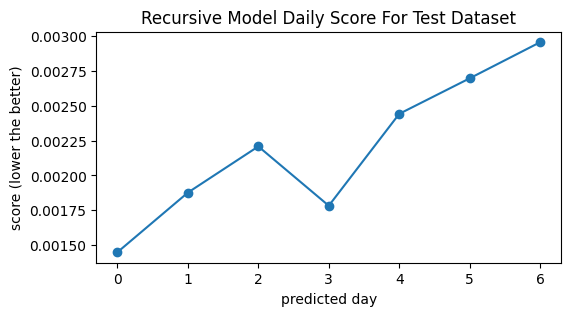

In [311]:
daily_score = {}
for i in range(7):
    daily_score[i] = np.mean([x.daily_score[i] for x in averaged_model.models])

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(daily_score.keys(), daily_score.values(), 'o-')
ax.set_xlabel('predicted day')
ax.set_ylabel('score (lower the better)')
ax.set_title("Recursive Model Daily Score For Test Dataset")

In [312]:
pred_df.to_csv("./predictions/recursive_model.csv", index=False)

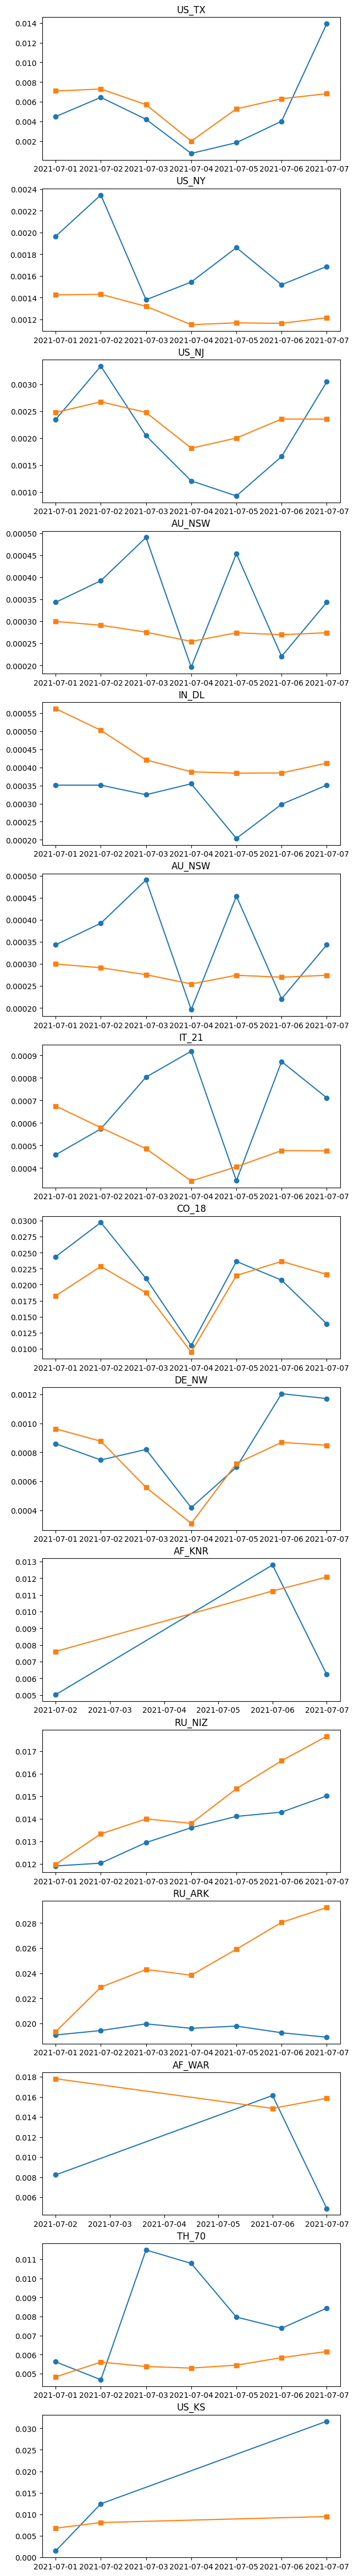

In [313]:
selected_locations = ['US_TX', 'US_NY', 'US_NJ', 'AU_NSW', 'IN_DL', 'AU_NSW', 'IT_21']
random_loations = np.random.choice(pred_df['location_key'].unique(), 8).tolist()
locations = selected_locations + random_loations
location_cnt = len(locations)
fig, ax = plt.subplots(location_cnt, 1, figsize=(7, 4*location_cnt))
for i, location_key in enumerate(locations):
    tmp = pred_df[pred_df['location_key']==location_key]
    ax[i].plot(tmp['target_date'], tmp['target'], marker='o')
    ax[i].plot(tmp['target_date'], tmp['prediction'], marker='s')
    ax[i].set_title(location_key)